In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy as sp
from tensorflow.keras import layers
from scipy.integrate import odeint

In [3]:
# Define a non-linear dynamical system (example: Lorenz system)
def duffing_oscillator(t, x):
     # Parameters
    alpha = 0.1
    beta = 0.3
    delta = 0.2
    omega = 1.0

    # System of equations
    dxdt = [x[1], -delta * x[1] - alpha * x[0] - beta * x[0]**3 + np.cos(omega * t)]
    dxdt = np.array(dxdt)
    return dxdt

In [4]:
# Generate time-series data from the non-linear system
timesteps = np.linspace(0, 10, 1000)
x0 = np.array([0.1, 0.0])  # Updated initial condition
# data = []
# x = x0
# for t in timesteps[:-1]:  # Exclude the last timestep
#     data.append(x)
#     k1 = duffing_oscillator(x, t)
#     k2 = duffing_oscillator(x + 0.5 * k1, t + 0.5)
#     k3 = duffing_oscillator(x + 0.5 * k2, t + 0.5)
#     k4 = duffing_oscillator(x + k3, t + 1.0)
#     x = x + (k1 + 2 * k2 + 2 * k3 + k4) * (1/6) * 0.01
data = odeint(duffing_oscillator, x0, t=timesteps, tfirst = True)

data = np.array(data)
print(data)

[[ 0.1         0.        ]
 [ 0.10004955  0.0098968 ]
 [ 0.10019806  0.01977272]
 ...
 [-1.97538761 -2.48581652]
 [-2.00016105 -2.46376422]
 [-2.02470914 -2.44078982]]


In [5]:
# Define the Koopman operator neural network
model = tf.keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation = 'relu'),
    layers.Dense(4, activation = 'linear'),        # The Koopman operator predicts the state at the next time step
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(2),
])

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Split data into input and output
X = data[:-1]
y = data[1:]


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dense_4 (Dense)             (None, 64)                320       
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 2)                 2

In [8]:
# Train the Koopman operator
model.fit(X, y, epochs=100, verbose=1)


Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 1.3343
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2483
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0694
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 8.9987e-04
Epoch 11/100
32/32 [==============================] - 0s 2ms/step - loss: 5.8341e-04
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 3.8197e-04
Epoch 13/100
32/32 [=====

In [9]:
linear_layer_weights = model.layers[-3].get_weights()[0]
print("Linear Layer Weights (Koopman Operators):\n", linear_layer_weights)

Linear Layer Weights (Koopman Operators):
 [[ 0.3275465  -0.26931903  0.23408037  0.25353357 -0.14418337  0.11769435
   0.14607903 -0.19283447 -0.16975066 -0.05674097 -0.0880001  -0.0389144
  -0.269345    0.16450606 -0.14077742  0.30782327  0.27741343  0.00363574
  -0.05702425 -0.03963299  0.05717815 -0.21906126  0.2684549  -0.23661537
   0.26738867 -0.15227908  0.20802484  0.31158662  0.32057574  0.17568928
   0.05932102 -0.06535801 -0.22052605  0.30182552  0.11640517 -0.2983555
   0.10920505  0.04887277  0.2640289   0.10057082 -0.14434701 -0.0178642
  -0.26892024  0.1449273  -0.24407731 -0.23271267  0.23864788 -0.06212709
   0.25651795 -0.16573411 -0.08317193 -0.11629878 -0.25723654 -0.08875357
   0.10238715 -0.06203594  0.3015048  -0.20874701  0.23960046 -0.02940186
  -0.04299597  0.20436287  0.06373996  0.04296188]
 [-0.23757519  0.07564372 -0.08168115  0.2057194  -0.13960846  0.02300181
   0.14333852 -0.13581161  0.23878667  0.2110862  -0.12662633 -0.10890688
  -0.00693742  0.1294

32/32 [==============================] - 0s 2ms/step
(1000,)
(999, 2)


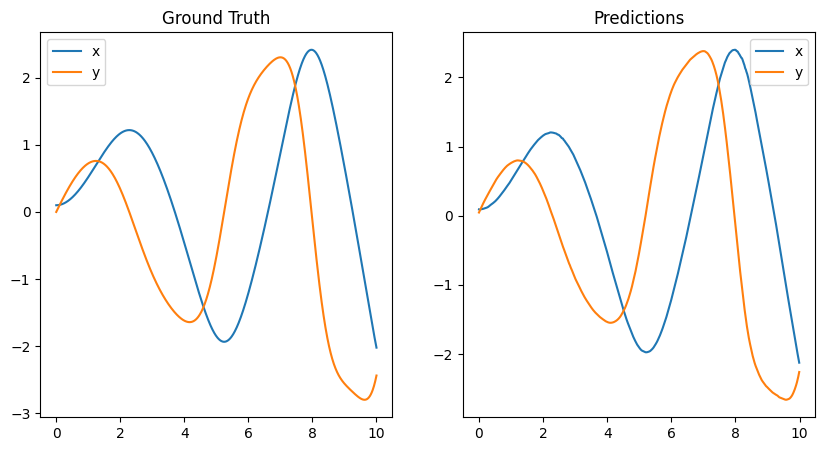

In [10]:
# Generate predictions from the Koopman operator
predictions = model.predict(X)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Ground Truth')
plt.plot(timesteps[:], data[:, 0], label='x')
plt.plot(timesteps[:], data[:, 1], label='y')
plt.legend()
print(timesteps.shape)
print(predictions.shape)
plt.subplot(122)
plt.title('Predictions')
plt.plot(timesteps[:-1], predictions[:, 0], label='x')
plt.plot(timesteps[:-1], predictions[:, 1], label='y')
plt.legend()

plt.show()

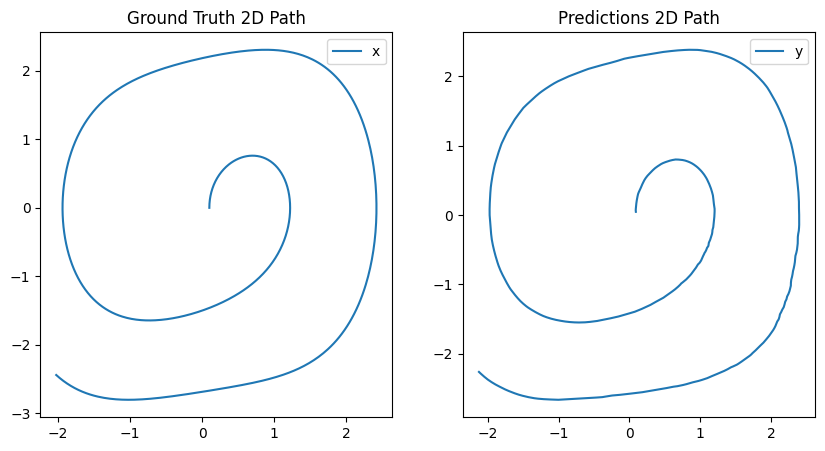

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Ground Truth 2D Path')
plt.plot(data[:, 0], data[:, 1], label='x')
plt.legend()

plt.subplot(122)
plt.title('Predictions 2D Path')
plt.plot(predictions[:, 0], predictions[:, 1], label='y')
plt.legend()

plt.show()